Imported required libraries for PDF extraction, data handling, and text cleaning

In [1]:
import pdfplumber
import pandas as pd
import re

This code extracts structured tabular data from a government trade notice PDF using pdfplumber, cleans the rows, and converts them into a list for further processing.

In [44]:
def extract_tables_from_pdf(pdf_path):
    all_rows = []

    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            table = page.extract_table(table_settings={"vertical_strategy": "text", "horizontal_strategy": "text"})

            if table:
                for row in table:
                    clean_row = [cell.replace('\n', ' ') if cell else '' for cell in row]
                    
                    if "ITC(HS)" in str(clean_row) or "Code" in str(clean_row):
                        continue
                        
                    if not any(clean_row):
                        continue

                    all_rows.append(clean_row)
            
            print(f"Processed page {i+1}/{len(pdf.pages)}")

    return all_rows

pdf_path = r"C:\Users\Abhishek singh\Desktop\hsn_classification\Trade_Notice_First_50_Pages (1).pdf" 

raw_data = extract_tables_from_pdf(pdf_path)

print(f"\nTotal rows extracted: {len(raw_data)}")

Processed page 1/50
Processed page 2/50
Processed page 3/50
Processed page 4/50
Processed page 5/50
Processed page 6/50
Processed page 7/50
Processed page 8/50
Processed page 9/50
Processed page 10/50
Processed page 11/50
Processed page 12/50
Processed page 13/50
Processed page 14/50
Processed page 15/50
Processed page 16/50
Processed page 17/50
Processed page 18/50
Processed page 19/50
Processed page 20/50
Processed page 21/50
Processed page 22/50
Processed page 23/50
Processed page 24/50
Processed page 25/50
Processed page 26/50
Processed page 27/50
Processed page 28/50
Processed page 29/50
Processed page 30/50
Processed page 31/50
Processed page 32/50
Processed page 33/50
Processed page 34/50
Processed page 35/50
Processed page 36/50
Processed page 37/50
Processed page 38/50
Processed page 39/50
Processed page 40/50
Processed page 41/50
Processed page 42/50
Processed page 43/50
Processed page 44/50
Processed page 45/50
Processed page 46/50
Processed page 47/50
Processed page 48/50
P

This step converts the extracted PDF table rows into a structured pandas DataFrame, assigns meaningful column names, removes unwanted columns, and normalizes HSN codes.

In [23]:
df = pd.DataFrame(raw_data)

display(df.head())

df.columns = [
    "Chapter", 
    "HSN_Code", 
    "Description", 
    "Export_Policy", 
    "Policy_Condition", 
    "Notification_No", 
    "Notification_Date"
] + [f"Extra_{i}" for i in range(len(df.columns) - 7)]

df = df.iloc[:, :7]

df['HSN_Code'] = df['HSN_Code'].astype(str).str.replace(r'\s+', '', regex=True)

print("\nDataFrame Info:")
df.info()
display(df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,Min,istry of Com,merce & Ind,ustry,,,None,None,None,None,None,None,None
1,,,,Department,of Commerc,e,,,None,None,None,None,None,None,None
2,,,Direc,torate Gener,al of Foreign,Trade,,,None,None,None,None,None,None,None
3,,,,,,Van,ijya Bhawan,", New Delhi",None,None,None,None,None,None,None
4,,,,,,,Dated: 2nd A,ugust 2024,None,None,None,None,None,None,None



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4228 entries, 0 to 4227
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Chapter            4228 non-null   object
 1   HSN_Code           4228 non-null   object
 2   Description        4228 non-null   object
 3   Export_Policy      4228 non-null   object
 4   Policy_Condition   4228 non-null   object
 5   Notification_No    4228 non-null   object
 6   Notification_Date  3442 non-null   object
dtypes: object(7)
memory usage: 231.3+ KB


,Chapter,HSN_Code,Description,Export_Policy,Policy_Condition,Notification_No,Notification_Date
0,,,Min,istry of Com,merce & Ind,ustry,
1,,,,Department,of Commerc,e,
2,,,Direc,torate Gener,al of Foreign,Trade,
3,,,,,,Van,ijya Bhawan
4,,,,,,,Dated: 2nd A


This step cleans formatting inconsistencies in HSN codes and chapter numbers, removes invalid rows, and restores missing hierarchical information to ensure structural correctness.

In [7]:
def clean_dataframe(df):
    clean_df = df.copy()

    clean_df['HSN_Code'] = clean_df['HSN_Code'].astype(str).str.replace(r'[.\s]', '', regex=True)
    clean_df['Chapter'] = clean_df['Chapter'].astype(str).str.replace(r'[.\s]', '', regex=True)

    is_valid_row = (
        clean_df['HSN_Code'].str.match(r'^\d+$') | 
        clean_df['Chapter'].str.match(r'^\d+$')
    )
    
    clean_df = clean_df[is_valid_row]

    clean_df['Chapter'] = clean_df['Chapter'].replace(['', 'nan', 'None'], float('nan'))
    clean_df['Chapter'] = clean_df['Chapter'].ffill()

    return clean_df.reset_index(drop=True)

df_clean = clean_dataframe(df)

print(f"Original rows: {len(df)}")
print(f"Clean rows: {len(df_clean)}")
display(df_clean.head(10))

Original rows: 4228
Clean rows: 2134


,Chapter,HSN_Code,Description,Export_Policy,Policy_Condition,Notification_No,Notification_Date
0,"any),Chapters",40,to 98 of Sched,ule-II (Export,Policy) shall,accordingl,y be re-notifi
1,"any),Chapters",1,Condoms except categories/ brands mentio,ned at (a) a,nd (b) be,low (which,are not allo
2,40,40,Rubber And Articles Thereof.,,,,
3,40,4001,"Natural rubber, balata, gutta-percha, gua","yule,",,,
4,40,400110,"Natural rubber latex, whether or not pre-",,,,
5,40,40011010,Prevulcanised,,Free,,
6,40,40011020,Other than prevulcanised,,Free,,
7,40,40012100,Natural rubber in other forms :,,Free,,
8,40,40012200,Natural rubber in other forms :,,Free,,
9,40,400129,Natural rubber in other forms :,,,,


This step enriches raw HSN item descriptions by reconstructing their full hierarchical context (Chapter → Heading → Subheading → Item).
The enriched context is later used for semantic embeddings and AI-driven classification.

In [25]:
def enrich_hsn_data(df):
    enriched_rows = []
    
    current_chapter = ""
    current_heading = ""
    current_subheading = ""
    
    for index, row in df.iterrows():
        code = str(row['HSN_Code']).strip()
        desc = str(row['Description']).strip()
        
        
        if len(code) == 2:
            current_chapter = desc
            current_heading = ""
            current_subheading = ""
            
        elif len(code) == 4:
            current_heading = desc
            current_subheading = ""
            
        elif len(code) == 6:
            current_subheading = desc
            
        elif len(code) >= 8:
            chap_txt = current_chapter if current_chapter else "Unknown Chapter"
            head_txt = current_heading if current_heading else "Unknown Heading"
            sub_txt = current_subheading if current_subheading else head_txt
            
            full_context = (
                f"Chapter: {chap_txt} > "
                f"Heading: {head_txt} > "
                f"Subheading: {sub_txt} > "
                f"Item: {desc}"
            )
            
            new_row = row.to_dict()
            new_row['contextual_description'] = full_context
            new_row['hierarchy_level'] = '8-digit'
            enriched_rows.append(new_row)

    return pd.DataFrame(enriched_rows)

df_final = enrich_hsn_data(df_clean)

display(df_final.head())

print(f"Final 8-digit items ready for AI: {len(df_final)}")

sample = df_final[df_final['HSN_Code'] == '40011010']
if not sample.empty:
    print("\n--- Enriched Sample ---")
    print(f"Code: {sample.iloc[0]['HSN_Code']}")
    print(f"Old Desc: {sample.iloc[0]['Description']}")
    print(f"New Context: {sample.iloc[0]['contextual_description']}")

,Chapter,HSN_Code,Description,Export_Policy,Policy_Condition,Notification_No,Notification_Date,contextual_description,hierarchy_level
0,40,40011010,Prevulcanised,,Free,,,Chapter: Rubber And Articles Thereof. > Headin...,8-digit
1,40,40011020,Other than prevulcanised,,Free,,,Chapter: Rubber And Articles Thereof. > Headin...,8-digit
2,40,40012100,Natural rubber in other forms :,,Free,,,Chapter: Rubber And Articles Thereof. > Headin...,8-digit
3,40,40012200,Natural rubber in other forms :,,Free,,,Chapter: Rubber And Articles Thereof. > Headin...,8-digit
4,40,40012910,Hevea,,Free,,,Chapter: Rubber And Articles Thereof. > Headin...,8-digit


Final 8-digit items ready for AI: 1663

--- Enriched Sample ---
Code: 40011010
Old Desc: Prevulcanised
New Context: Chapter: Rubber And Articles Thereof. > Heading: Natural rubber, balata, gutta-percha, gua > Subheading: Natural rubber latex, whether or not pre- > Item: Prevulcanised


This code constructs a Hierarchical Knowledge Graph from HSN (Harmonized System of Nomenclature) data. It maps relationships between Chapters (2 digits), Headings (4 digits), Subheadings (6 digits), and Items (8+ digits) using networkx, and includes a utility to visualize specific branches of the hierarchy.

Graph Built: 2142 nodes, 2105 edges


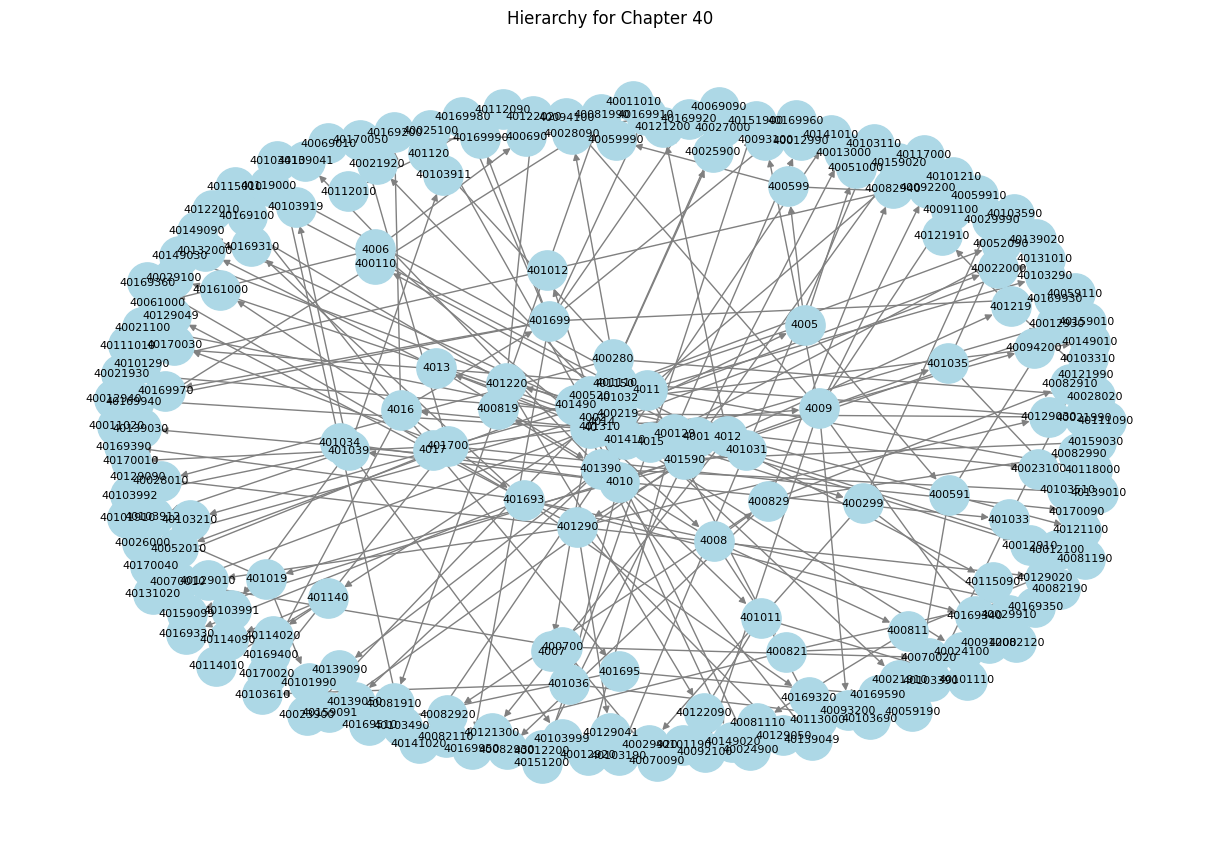

In [ ]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt

def build_knowledge_graph(df):
    G = nx.DiGraph()
    
    for index, row in df.iterrows():
        code = str(row['HSN_Code']).strip()
        desc = str(row['Description']).strip()
        
        G.add_node(code, title=desc, label=code, level=len(code))
        
        if len(code) == 4:
            parent = code[:2]
            G.add_edge(parent, code, label="HAS_HEADING")
            
        elif len(code) == 6:
            parent = code[:4]
            G.add_edge(parent, code, label="HAS_SUBHEADING")
            
        elif len(code) >= 8:
            parent_6 = code[:6]
            parent_4 = code[:4]
            
            if G.has_node(parent_6):
                G.add_edge(parent_6, code, label="CONTAINS_ITEM")
            else:
                G.add_edge(parent_4, code, label="CONTAINS_ITEM_DIRECT")

    return G

G = build_knowledge_graph(df_clean)

print(f"Graph Built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

def visualize_chapter(G, chapter_code):
    if str(chapter_code) not in G:
        print(f"Chapter {chapter_code} not found in graph.")
        return
        
    subgraph_nodes = list(nx.descendants(G, str(chapter_code))) + [str(chapter_code)]
    subgraph = G.subgraph(subgraph_nodes)
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, seed=42)
    nx.draw(subgraph, pos, with_labels=True, node_size=800, node_color="lightblue", font_size=8, edge_color="gray")
    plt.title(f"Hierarchy for Chapter {chapter_code}")
    plt.show()

visualize_chapter(G, "40")

this Keeps only documents whose HSN codes exist in the knowledge graph and enriches them with hierarchy info.

In [ ]:
def filter_docs_with_graph(docs, G):

    filtered = []

    for doc in docs:
        code = doc.metadata.get("hsn_code")

        if code and G.has_node(code):
            parents = list(nx.ancestors(G, code))

            hierarchy = {
                "chapter": next((p for p in parents if len(p) == 2), None),
                "heading": next((p for p in parents if len(p) == 4), None),
                "subheading": next((p for p in parents if len(p) == 6), None)
            }

            doc.metadata["hierarchy"] = hierarchy
            filtered.append(doc)

    return filtered

It takes all the HSN descriptions and turns them into a searchable database called a Vector Store.

In [36]:
import os
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document

load_dotenv()

def create_vector_store(df):
    documents = []
    
    for index, row in df.iterrows():
        page_content = row['contextual_description']
        
        metadata = {
            "hsn_code": row['HSN_Code'],
            "description": row['Description'],
            "policy": row['Export_Policy'],
            "condition": row['Policy_Condition']
        }
        
        doc = Document(page_content=page_content, metadata=metadata)
        documents.append(doc)

    print(f"Embedding {len(documents)} documents...")
    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(documents, embeddings)
    
    vector_store.save_local("hsn_vector_store")
    print("Vector store saved to 'hsn_vector_store/'")
    return vector_store

vector_db = create_vector_store(df_final)

Embedding 1663 documents...
Vector store saved to 'hsn_vector_store/'


This code creates the search tool fro the hsn data

In [37]:
def search_hsn(query, vector_store, k=4):
    results = vector_store.similarity_search(query, k=k)
    return results

query = "What is the HSN code for natural rubber latex?"
results = search_hsn(query, vector_db)

print(f"Query: {query}\n")
print("--- Top Search Results ---")
for doc in results:
    print(f"[Code: {doc.metadata['hsn_code']}] {doc.page_content[:100]}...")

Query: What is the HSN code for natural rubber latex?

--- Top Search Results ---
[Code: 40011020] Chapter: Rubber And Articles Thereof. > Heading: Natural rubber, balata, gutta-percha, gua > Subhead...
[Code: 40012100] Chapter: Rubber And Articles Thereof. > Heading: Natural rubber, balata, gutta-percha, gua > Subhead...
[Code: 40012200] Chapter: Rubber And Articles Thereof. > Heading: Natural rubber, balata, gutta-percha, gua > Subhead...
[Code: 40011010] Chapter: Rubber And Articles Thereof. > Heading: Natural rubber, balata, gutta-percha, gua > Subhead...


In [39]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
import re

llm = ChatOpenAI(model_name="gpt-4", temperature=0)

def format_docs(docs):
    formatted = []
    for doc in docs:
        info = (f"HSN Code: {doc.metadata.get('hsn_code', 'N/A')}\n"
                f"Full Context: {doc.page_content}\n"
                f"Policy: {doc.metadata.get('policy', 'N/A')}\n"
                f"Condition: {doc.metadata.get('condition', 'N/A')}\n"
                "---")
        formatted.append(info)
    return "\n".join(formatted)

template = """
You are an expert Trade Classification Assistant. 
Your goal is to identify the correct 8-digit HSN code.

CONTEXT FOUND:
{context}

USER QUERY: 
{question}

LOGIC RULES:
1. **Direct Code Match:** If the user asks about a specific 8-digit code (e.g., "40011010"), and that code is in the context, showing the full details is your ONLY priority.
2. **Specific Description:** If the user query contains a specific keyword (like "Prevulcanised") that matches exactly ONE item in the context, return that single code immediately. Do NOT ask for clarification.
3. **Ambiguity (Disambiguation):** Only if the user asks a broad term (e.g., "Natural rubber latex") that matches MULTIPLE specific items (e.g., "Prevulcanised" AND "Other"), then list the options and ask them to clarify.
4. **Broad Category:** If the query is very general (e.g., "Rubber products"), summarize the Chapter or Heading details.

FORMATTING RULES:

A. SINGLE EXACT ANSWER (including Direct Code Match or Specific Description):
- Output must include:
  • HSN Code
  • Description
  • Structured Hierarchy in the following EXACT format:
    • Chapter (XX): <Chapter Name>
    • Heading (XXXX): <Heading Name>
    • Subheading (XXXXXX): <Subheading Name>
    • Specific Code: <Item Description>
  • Trade Status (Policy)

- DO NOT show hierarchy as a single arrow-separated line.
- DO NOT omit any hierarchy level if present in context.

B. AMBIGUOUS ANSWERS:
- List ONLY the conflicting descriptions.
- Do NOT show HSN codes.
- Ask for clarification.

C. BROAD CATEGORY:
- Summarize at Chapter or Heading level only.

"""

prompt = ChatPromptTemplate.from_template(template)

def get_hsn_answer(query):
    code_match = re.search(r'\b(\d{8})\b', query)
    
    context_text = ""
    
    if code_match:
        target_code = code_match.group(1)
        
        match_row = df_final[df_final['HSN_Code'] == target_code]
        
        if not match_row.empty:
            row = match_row.iloc[0]
            
            info = (f"HSN Code: {row['HSN_Code']}\n"
                    f"Full Context: {row['contextual_description']}\n"
                    f"Policy: {row['Export_Policy']}\n"
                    f"Condition: {row['Policy_Condition']}\n"
                    "---")
            context_text = info
        else:
            return f"HSN Code {target_code} not found in the provided Trade Notice."

    if not context_text:
        docs = vector_db.similarity_search(query, k=5)
        docs = filter_docs_with_graph(docs, G)
        context_text = format_docs(docs)

    chain = (
        {"context": lambda x: context_text, "question": lambda x: x}
        | prompt
        | llm
        | StrOutputParser()
    )
    return chain.invoke(query)

In [43]:
test_cases = [
    "What is the HSN code for natural rubber latex?",       # Case 1: Disambiguation
    "HSN code for prevulcanised rubber",         # Case 2: Specific
    "Rubber products classification",            # Case 3: Broad
    "Natural rubber latex",                      # Case 4: Similar Products
    "Tell me about HSN 40011010"                 # Case 5: Direct Lookup
]

print("=== FINAL RE-VALIDATION ===\n")
for i, q in enumerate(test_cases):
    print(f"Test Case {i+1}: {q}")
    print("-" * 40)
    print(get_hsn_answer(q))
    print("\n" + "="*50 + "\n")

=== FINAL RE-VALIDATION ===

Test Case 1: What is the HSN code for natural rubber latex?
----------------------------------------
The term "natural rubber latex" matches multiple specific items in the context. Could you please specify if you are referring to:

- Natural rubber latex, whether or not prevulcanised
- Natural rubber latex, other than prevulcanised
- Natural rubber in other forms

Please provide more details for an accurate HSN code.


Test Case 2: HSN code for prevulcanised rubber
----------------------------------------
The HSN code for prevulcanised rubber is:

• HSN Code: 40011010
• Description: Prevulcanised
• Structured Hierarchy:
    • Chapter (04): Rubber And Articles Thereof.
    • Heading (4001): Natural rubber, balata, gutta-percha, gua
    • Subheading (400110): Natural rubber latex, whether or not pre-
    • Specific Code: Prevulcanised
• Trade Status (Policy): Free


Test Case 3: Rubber products classification
----------------------------------------
The user 